For our final project, we have chosen to analyze Spotify music data, focusing on key attributes of songs. This dataset comprises various features, including track duration, explicit content, danceability, energy, and more.

Our central question revolves around predicting the danceability of a song based on its musical characteristics and qualities. Specifically, we aim to investigate the following:

Can we predict the danceability of a song based on musical characteristics/qualities? What qualities of a song contribute the most to its danceability?

The motivation and value behind this question is to provide valuable insights for clubs and DJs, offering a greater understanding of the factors that influence a song's danceability. By determining which musical attributes contribute significantly to a song's danceability, stakeholders can make informed decisions to enhance the appeal and marketability of their music. 

Our question is relevant to the music industry, where the abitity to predict a song's danceability directly impacts revenue generation.


We found our dataset on this website: https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset/tree/main 

Our data set is 6 months old, 20.1 MB, containing 20 columns, and 114001 rows. This is a recent dataset with a large enough size to give us accurate and unbiased data.

The columns that we are working with to analyze are as follows: track_id, artists, album_name, track_name, popularity, duration_ms, explicit, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, track_genre

When we first began our prokject, our primary goal was to assess song popularity based on musical characteristics and quality. However, as we began to construct a model, we encountered challenges with accuracy in predicting a song's popularity from the available data. This discrepancy was due to a high amount of zeros in the popularity data, skewing our results. Additionally, we realized that popularity is a subjective quality influenced by various factors, including seasonal considerations (e.g., Christmas songs), extending beyond mere musical features.

We shifted our focus to identifying a more robust target variable for prediction. We found that danceability proved to be a superior target variable. Not only does it have a more direct correlation with the musical features in our X variable, but it also provides a more nuanced and reliable indicator of a song's appeal.

In [110]:
# step 1: import the libraries and upload the dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from lime import lime_tabular
from sklearn.inspection import permutation_importance
#below is a new package needed for this lab
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import OneHotEncoder
from fairlearn.metrics import MetricFrame


# open the dataset.csv file 
music = pd.read_csv('dataset.csv')
# inspect the types of each column
music.dtypes


Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

We decided that the best model to use for our question would be Random forest. This is because we have alot of key features that are both numerical and categorical. 

We want to use random forest to be able to determine what factors contribute the most to danceability. RF is an adequate model for our question because they work with both numerical and categorical data, flexible, and easy to interpret.



First, lets clean our data set a little bit for manipulation. 

In [111]:
# check how many nas 
music.isna().sum()
# not too many nas, so we can drop them 
music = music.dropna()


We plotted the correlation matrix for the data. 
We can see initially that the columns that correlate the most with danceability are: Loudness, Valence, and Time 
The columns that seem to correlate the least with danceability are: Instrumentalness and Acousticness. This could be due to danceability only being high for more techno pop music and less instrumental songs. 

<AxesSubplot:>

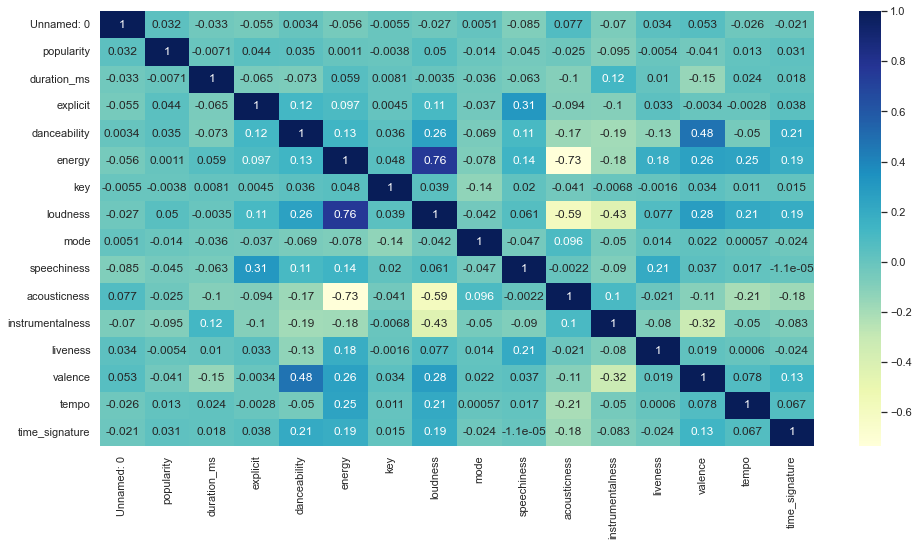

In [112]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr =music.corr()
sns.heatmap(corr,annot=True, cmap="YlGnBu")


Lets do some more exploratory data analysis on the data

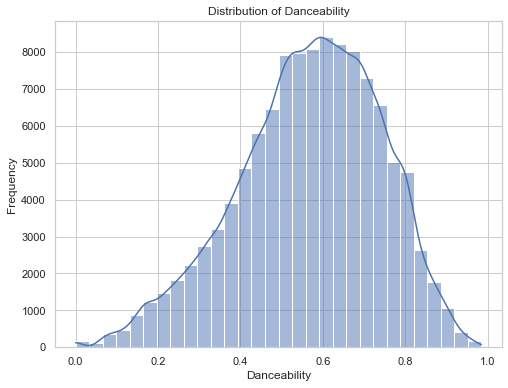

In [113]:

import seaborn as sns
# Distribution of the target variable (danceability)
plt.figure(figsize=(8, 6))
sns.histplot(music["danceability"], bins=30, kde=True)
plt.title("Distribution of Danceability")
plt.xlabel("Danceability")
plt.ylabel("Frequency")
plt.show()


We can see from the danceability distribution that most of the data has a danceability around .6/.7. this means that most of the data has an average danceability score. This is good because we don't want the distribution to be skewed too much in one direction. When we first tried to determine popularity, the distribution showed a max at 0.0, which led to errors and bias later on. 

In [114]:
# lets fix some of the columns values --> example some of the track names are not legible
# lets remove the ones that are not in english, with any letters that contain special symbols 
# in another language other than english 
music = music[music['track_name'].str.contains('^[a-zA-Z ]+$')]
music['track_name'].value_counts()
# lets drop track_id because it is just a bunch of letters 
music = music.drop(['track_id'], axis = 1)
# also remove the unnamed column
music = music.drop(['Unnamed: 0'], axis = 1)
# lets also drop album name because this wont really contribute to danceability 
music = music.drop(['album_name'], axis = 1)
# lets also drop artists since we dont have any tell about the artists fame 
music = music.drop(['artists'], axis = 1)
# lets also drop explicit because this won't really contribute to danceability
music = music.drop(['explicit'], axis = 1)
# lets also drop the track name because this wont really contribute to danceability
music = music.drop(['track_name'], axis = 1)
# we want to be able to predict danceability of the track, so maybe we can add this in later 



In [72]:
music.head()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
2,57,210826,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
4,82,198853,0.618,0.443,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
5,58,214240,0.688,0.481,6,-8.807,1,0.1050,0.2890,0.000000,0.1890,0.6660,98.017,4,acoustic
6,74,229400,0.407,0.147,2,-8.822,1,0.0355,0.8570,0.000003,0.0913,0.0765,141.284,3,acoustic


In [115]:
# lets normalize the numerical data, as a min max scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# select all the numerical columns and min max scale them 
music[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']] = scaler.fit_transform(music[['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']])
music.head()


,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,0.048552,0.686294,0.460989,0.090909,0.779395,0.0,0.148187,0.032329,0.000001,0.354151,0.718593,0.361245,0.8,acoustic
2,57,0.043952,0.444670,0.358987,0.000000,0.720948,1.0,0.057720,0.210843,0.000000,0.109419,0.120603,0.313643,0.8,acoustic
4,82,0.041176,0.627411,0.442989,0.181818,0.721984,1.0,0.054508,0.470884,0.000000,0.074791,0.167839,0.492863,0.8,acoustic
5,58,0.044743,0.698477,0.480990,0.545455,0.739080,1.0,0.108808,0.290161,0.000000,0.182534,0.669347,0.402746,0.8,acoustic
6,74,0.048258,0.413198,0.146983,0.181818,0.738787,1.0,0.036788,0.860442,0.000003,0.083321,0.076884,0.580527,0.6,acoustic


In [116]:
# lets separate our X and Y variables for our random forest 
# we will use the danceability as our target variable
y = music['danceability']
X = music.drop(['danceability'], axis = 1)


In [117]:
# right now danceability is on a 0-1.0 scale, lets change it to a more condensed scale 
# lets use either not danceable or danceable 
# the cutoff is 0-0.6 and then 0.6-1.0

# lets create a function that will change the danceability to either 0 or 1
def danceability_change(danceability):
    if danceability < 0.60:
        return 0
    else:
        return 1

# lets apply this function to our y variable
y = y.apply(danceability_change)


In [118]:
# preprocessing --> turn objects to categorical 

X['track_genre']= X['track_genre'].astype('category') 


In [119]:
# one hot encode the categorical variable --> its only genre -- which could predict danceability 

category_list = list(X.select_dtypes('category')) #select function to find the categorical variables and create a list  

X_1h = pd.get_dummies(X, columns = category_list) 
X_1h.info()

X= X_1h


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68607 entries, 0 to 113999
Columns: 127 entries, popularity to track_genre_world-music
dtypes: float64(12), int64(1), uint8(114)
memory usage: 14.8 MB


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify= y, random_state=21) 
#start with 10% of our dataset, could do 20% but random forest does require more training data
#because of the sampling so 90% might be a better approach with this small of a dataset
#remember, use random_state to create reproducible results


In [121]:
#Check the output
print(y_train.value_counts())
print(y_test.value_counts())


0    24462
1    23562
Name: danceability, dtype: int64
0    10484
1    10099
Name: danceability, dtype: int64


We can see that the value counts for not danceable (0) and danceable (1) are relatively even. This will be good for our results

In [122]:

random_grid = {'n_estimators': [500], #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
            'max_features': [5], #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification it is sqrt(p) where p is number of variables in x and regression it is simply p.
            'bootstrap': [True], #<-Whether bootstrap samples are used when building trees
            'max_samples' : [150],  #<- Size of sample to draw each time.
            'min_samples_leaf': [10], #<- Minimum numbers of data points in terminal nodes.
            'max_leaf_nodes': [None], #<- Maximum number of terminal nodes trees in the forest can have. 
            'max_depth': [None], #<-The maximum depth of the tree
            'min_samples_split': [None], #<-The minimum number of samples required to split an internal node
            'oob_score': True, #<-Whether to use out-of-bag samples to estimate the generalization score
            'warm_start': True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
                }


In [123]:

print('max_features = ' + str(np.sqrt(X.shape[1]))) #around 11

RFC = RandomForestClassifier(n_estimators=1000, #<- Number of trees to grow. This should not be set to too small a number, to ensure that every input row gets predicted at least a few times.
                max_features= 11, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                bootstrap= True, #<-Whether bootstrap samples are used when building trees
                max_samples = 100,  #<- Size of sample to draw each time.
                min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                max_depth= None, #<-The maximum depth of the tree
                oob_score =True, #<-Whether to use out-of-bag samples to estimate the generalization score
            warm_start =True, #<- Whether to reuse the solution of the previous call to fit and add more estimators to the ensemble
            random_state= 1984,
            n_jobs= -1, #<- Number of cores to use for parallel processing (-1 will use all available)
            verbose=True) #<- Whether to print progress messages to stdout.

song_RF= RFC.fit(X_train,y_train)

# finished in 22 seconds



max_features = 11.269427669584644


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


In [125]:
print('OOB error rate: ' + str(1-song_RF.oob_score_))
# 25% error rate, not bad


OOB error rate: 0.25553889721805767


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


False Positive Rate: 0.2168
True Positive Rate: 0.7059


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.0s finished


0.7452523738130935

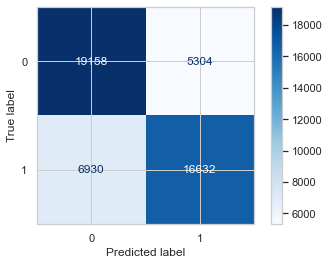

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Generate predictions on the training set
y_pred_train = song_RF.predict(X_train)

# Obtain the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Calculate false positive rate (FPR) and true positive rate (TPR)
fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1])
tpr = cm[1, 1] / (cm[1, 0] + cm[1, 1])

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=song_RF.classes_).plot(cmap='Blues')

# Display FPR and TPR
print(f"False Positive Rate: {fpr:.4f}")
print(f"True Positive Rate: {tpr:.4f}")

song_RF.score(X_train,y_train) 
# 75% accurate, not terrible 


We can see from the confusion matrix that we have a pretty good estimate from our model. There are definitely more correct predictions than incorrect and we can see that the False positive rate is 21% and the True positive rate is 70%. 

In [127]:
#calcuating recall and precision
#recall = TP/(TP+FN)
#precision = TP/(TP+FP)

recall = 13613/(13613+8955)
print(recall)
#not bad because .60 is closish to 1

precision = 13613/(13613+3735)
print(precision)
#not bad because .78 is close to 1


0.603199220134704
0.7847014065021904


Recall is the ratio of correctly predicted positive observations to the total actual positives. Precision is the ratio of correctly predicted positive observations to the total predicted positives. A recall of 60.29% indicates that the model is capturing a significant portion of the actual positive instances.A precision of 78.45% indicates that when the model predicts positive, it is correct about 78.45% of the time.

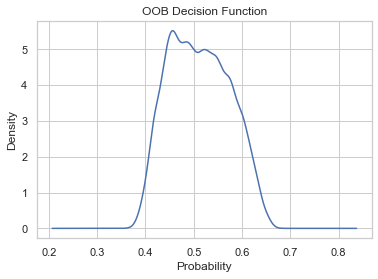

In [128]:
# View the percentage of trees that voted for 
# each data point to be in each class -- either below or above 0.60
xx = pd.DataFrame(song_RF.oob_decision_function_)


#Creating a density plot of the positive class probabilities 
xx[0].plot(kind='density')
plt.title("OOB Decision Function")
plt.xlabel("Probability")
plt.show()


In [129]:
#determining feature importance

np.argmax(song_RF.oob_decision_function_,axis=1)
print(pd.DataFrame(song_RF.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False))


                         importance
valence                    0.162652
acousticness               0.122368
tempo                      0.101771
energy                     0.101491
duration_ms                0.081047
...                             ...
track_genre_funk           0.000000
track_genre_french         0.000000
track_genre_forro          0.000000
track_genre_electronic     0.000000
track_genre_world-music    0.000000

[127 rows x 1 columns]


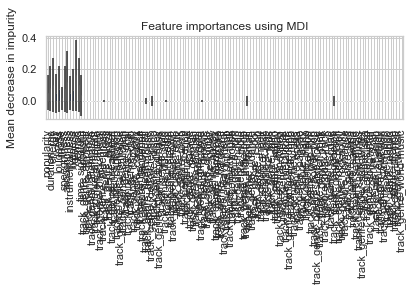

In [130]:
#Here we compute both the mean and standard
# deviation of accumulation of the impurity decrease within each tree.
importances = song_RF.feature_importances_

std = np.std([tree.feature_importances_ for tree in song_RF.estimators_], axis=0)

#graph it
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


In [131]:
 #Permutation feature importance does not have a bias toward 
 # high-cardinality features and can be computed on a test set. 
 # This will allow us to view the mean decrease in accuracy of each feature...

result = permutation_importance(
    song_RF, X_test, y_test, n_repeats=5, random_state=42, n_jobs=2, scoring='precision'
)

# Combine results and column names to visualize
forest_importances = pd.Series(result.importances_mean, index=X.columns)

# runs in 5 minutes 44 seconds


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 182 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 432 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 782 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=

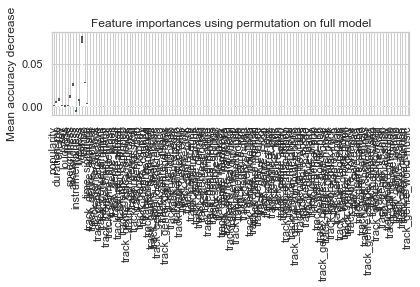

In [132]:
#The same features are detected as most important using both methods. 
# Although the relative importances vary
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [133]:
n_estimators_list = [100,200,300,400,500,600,700,800,900,1000]
forest_list = [RandomForestClassifier( n_estimators = n,
            max_features= 11, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p)
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                    warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in n_estimators_list]

forest_list[:3]


[RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        oob_score=True, random_state=1984, warm_start=True),
 RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                        n_estimators=300, oob_score=True, random_state=1984,
                        warm_start=True)]

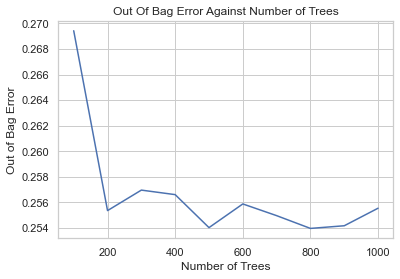

In [134]:
# Let's visualize the results of the random forest.
# Let's start by looking at how the error rate changes as we add more trees.

oob_errors = ([1-i.oob_score_ for i in forest_list])
plt.plot(n_estimators_list,oob_errors)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Out of Bag Error')
plt.show()

# we can see that the more trees we have directly improves the error rate


In [135]:
# We want to do the best we can to label a song as danceable 
# later we can certainly adjust the threshold but want to tune to optimize the models ability 
# to identify the positive target class. 

pd.DataFrame(list(zip(n_estimators_list,oob_errors)), columns = ['number of trees','oob_error'])
# in the graph and dataframe above we see that a greater number of trees
# minimizes the oob error.


,number of trees,oob_error
0,100,0.269428
1,200,0.255351
2,300,0.256955
3,400,0.256601
4,500,0.254019
5,600,0.255872
6,700,0.254956
7,800,0.253956
8,900,0.254165
9,1000,0.255539


In [136]:
# Let's grab our random forest model we made with 500ish trees.

song_RF_eng = forest_list[4]
song_RF_eng #good


RandomForestClassifier(max_features=11, max_samples=100, min_samples_leaf=5,
                       n_estimators=500, oob_score=True, random_state=1984,
                       warm_start=True)

original model error: 0.25553889721805767


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.1s finished


new model error: 0.25401882392137265


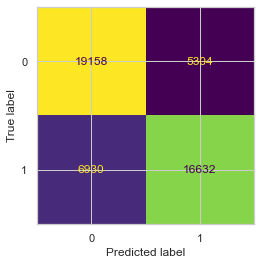

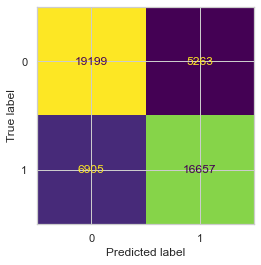

In [137]:
# Let's compare the confusion matrices between our 2 random forest models and the associated total error rates.
#original
print('original model error: ' +str(1-song_RF.oob_score_))
ConfusionMatrixDisplay.from_estimator(song_RF,X_train,y_train, colorbar= False)

#New
print('new model error: ' + str(1-song_RF_eng.oob_score_))
ConfusionMatrixDisplay.from_estimator(song_RF_eng,X_train,y_train, colorbar= False)


# not too much difference but it gets slightly better


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.6s finished


0.7499392702715834

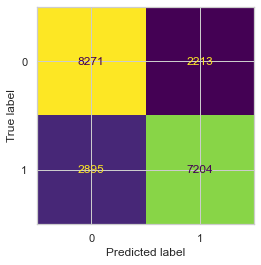

In [148]:
#Use the .predict function on our testing data with new model

song_predict = song_RF_eng.predict(X_test)

#create confusion matrix of test data predictions
ConfusionMatrixDisplay.from_predictions(y_test,song_predict, colorbar= False)

song_RF.score(X_test,y_test) 
# accuracy didnt improve


In [140]:
# There are a lot of parameters to set for the random forest.
# The package can help you identify the right number of variables to 
# randomly sample as candidates at each split (the max_features parameter)
#Let's explore for ourselves

max_features_list = [6,7,8,9,10,11,12,13,14,15]

forest_list2 = [RandomForestClassifier(n_estimators = 200,
            max_features= n, #<- Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) where p is number of variables in x) and regression (p).
                    bootstrap= True, #<-Whether bootstrap samples are used when building trees
                    max_samples = 100,  #<- Size of sample to draw each time.
                    min_samples_leaf= 5, #<- Minimum numbers of data points in terminal nodes.
                    max_leaf_nodes= None, #<- Maximum number of terminal nodes trees in the forest can have. 
                    max_depth= None, #<-The maximum depth of the tree
                    oob_score=True,
                    warm_start=True,
                    random_state= 1984).fit(X_train, y_train) for n in max_features_list]
forest_list2[:3]


[RandomForestClassifier(max_features=6, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=7, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True),
 RandomForestClassifier(max_features=8, max_samples=100, min_samples_leaf=5,
                        n_estimators=200, oob_score=True, random_state=1984,
                        warm_start=True)]

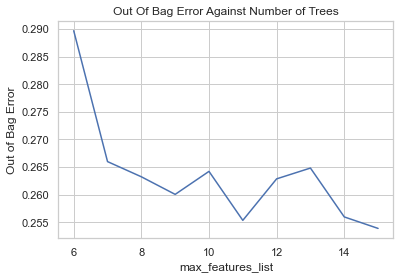

In [141]:
oob_errors1 = ([1-i.oob_score_ for i in forest_list2])
  #for error simply do 1-forest.oob_score_ 
plt.plot(max_features_list,oob_errors1)
plt.title('Out Of Bag Error Against Number of Trees')
plt.xlabel('max_features_list')
plt.ylabel('Out of Bag Error')
plt.show() # Looking at the OOB error graph, 12 seems to be the right 
# value to use in our random forest without overfitting


In [142]:
#assign correct model
song_RF_tune = forest_list2[6]
song_RF_tune #good


RandomForestClassifier(max_features=12, max_samples=100, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=1984,
                       warm_start=True)

Text(0.5, 0, 'False Positive Rate')

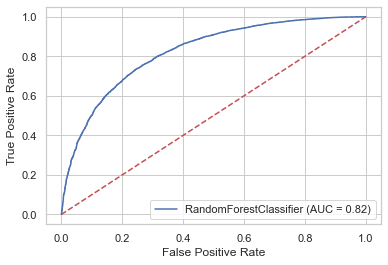

In [143]:
# Let's see how our relative true positives compare to the false positives.
# To do that we'll need to plot a ROC curve.

#Quickest and easiest method is to simply use the sklearn function RocCurveDisplay with our model and testing features + target
#This will give us an ROC plot with all reasonable thresholds given the probabilities of prediction
metrics.RocCurveDisplay.from_estimator(song_RF_tune, X_test,y_test)
#Set labels and midline...
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


In [144]:
#We can see where our optimal threshold is (closest point to top left corner), but let's get the exact value of it now 
#First get prediction probabilities of test data, only want positive class so extract second column
pred = song_RF_tune.predict_proba(X_test)[:,1]
#Use roc_curve function to get fpr, tpr and threshold values
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred, pos_label=1)
pd.DataFrame(list(zip(thresholds, tpr, fpr)),columns = ['thresholds','tpr','fpr']).head(27) #good


,thresholds,tpr,fpr
0,inf,0.000000,0.000000
1,0.641518,0.000099,0.000000
2,0.635737,0.000792,0.000000
3,0.635454,0.000792,0.000095
4,0.634922,0.001188,0.000095
5,0.633236,0.001485,0.000095
6,0.633213,0.001782,0.000095
7,0.633134,0.001881,0.000095
8,0.633039,0.001881,0.000191
9,0.632610,0.002178,0.000191


In [145]:
#Locate index of best threshold, this is where true postive rate is highest and false positive rate is the lowest
ix = np.argmax(tpr-fpr) #np.argmax returns the index of maximum values along and axis
print('Best threshold: ' + str(thresholds[26]))


Best threshold: 0.6190055837634268


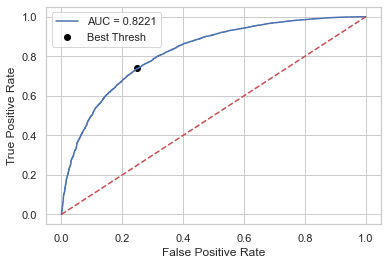

In [146]:
# plot the roc curve for the model with best threshold highlighted
#Get auc score first to add to plot
auc = metrics.roc_auc_score(y_test, pred)
#plot fpr and tpr
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % auc) 
#add in best threshold highlight
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Thresh')
# axis labels
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()


Fairness eval: Since our data doesn't include demographic factors such as gender, race, or age, and it primarily focuses on numerical features of musical quality, the potential for bias is reduced. We ensured that preprocessing steps did not introduce bias, and the dataset provided sufficient information to avoid misleading or mislabeled data.

The ROC curve above demonstrates the model's performance, with an AUC value of .82. The optimal threshold for equality of odds and equal opportunity is determined by the point on the curve where True Positive Rate (sensitivity) equals False Positive Rate. The red dot on the ROC curve indicates the best threshold, which is .82. An AUC of 0.82 is generally considered to be a good performance, indicating that the model has a relatively high ability to discriminate between positive and negative cases.

Conclusion: In conclusion, we found that we can pretty accurately predict song danceability with musical features. # add more 

